In [2]:
import pandas as pd
import os
import re
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import re
from collections import defaultdict

pd.set_option('display.max_columns', None)

In [3]:
folder = '/media/data_1/darius/models/finetuned'
numFolds= 1000

sheets = ['overall', 'gender' ,'language', 'insurance', 'ethnicity'] 

allowed_models = {'overall': ['baseline'],
                 'gender': ['baseline'],
                 'language': ['baseline'],
                 'insurance': ['baseline'],
                 'ethnicity': ['baseline']}
model = 'baseline'

In [4]:
def gap_significant(lower, upper):
    return (((lower <0) & (upper < 0)) | ((lower >0) & (upper > 0)))

def add_to_dict(gap_dict, model, sheet, name, num_sig, num_favor):
    if model not in gap_dict:
        gap_dict[model] = {}
    if sheet not in gap_dict[model]:
        gap_dict[model][sheet] = {}
    gap_dict[model][sheet][name] = [num_sig, num_favor]

def add_gap(model, gap, sheet, res):
    res[model+'_' + gap+'_sig'] = multipletests(res[model+'_'+gap + '_p'], alpha = 0.05, method = "fdr_bh")[0]
    add_to_dict(gap_infos_naive, model, sheet, gap, res[model+'_' + gap + 'naive_sig'].astype(int).sum(), (res.loc[res[model+'_' + gap + 'naive_sig'], model+'_'+gap] > 0).astype(int).sum() )

In [20]:
def get_seeds(finetuned_dir):
    p = Path(folder)
    seeds = [f.name.split('_seed')[1] for f in p.glob('*_seed[0-9]*')]

    return seeds

def get_target_name(mname):
    target = None
    if 'inhosp_mort' in mname:
        target = 'inhosp_mort'
    elif 'phenotype' in mname:
        mname = mname.split('seed')[0]
        name = re.findall(r'.*512_(?:lambda1_)*(.*)', mname)[0]
        if name.endswith('_gs'):
            name = name[:-3]
        name = name.replace('_', ' ')
        if 'phenotype_all' in mname:
            target = 'phenotype_all_%s' % name
        else:
            target = 'phenotype_first_%s' % name

    assert(target)
    return target

def populate_df(*, df, res, idx, model, columns, multi=False):
    for i in columns:
        col = model + '_' + columns[i]
        res.loc[idx, col] = df.loc[i, 'avg']
        res.loc[idx, col + '_p'] = df.loc[i, 'p']
        res.loc[idx, col + '_favor'] = df.loc[i, 'favor']
        
        res.loc[idx, col + 'lowerCI'] = df.loc[i, '2.5%']
        res.loc[idx, col + 'upperCI'] = df.loc[i, '97.5%']
        if multi and ('dgap_' in col or 'egap_' in col):
            res.loc[idx, col + 'naive_sig'] = gap_significant(df.loc[i, '2.5%'], df.loc[i, '97.5%'])
        else:
            res.loc[idx, col + 'naive_sig'] = gap_significant(df.loc[i, '2.5%'], df.loc[i, '97.5%'])

In [21]:
seeds = get_seeds(folder)

dfs_list = []
gap_infos_naive_list = []
for seed in seeds:
    dfs = {}
    gap_infos_naive = {}
    for sheet in sheets:
        res = pd.DataFrame()
        for root, dirs, files in tqdm(os.walk(folder)):
            for d in dirs:
                mname = d
                if f'_seed{seed}' not in mname:
                    continue
                file = Path(root) / d / 'results.xlsx'
                # files = sorted([f for f in p.glob('*.*') if f.stem == 'results'])

                target = get_target_name(mname)

                if sheet == 'overall':
                    print(os.path.join(root, file))
                    df = pd.read_excel(os.path.join(root, file), index_col=0, sheet_name = 'all')
                    columns = ['all_auroc', 'all_auprc', 'all_recall', 'all_class_true_count']
                    for i in columns:
                        res.loc[f'{target}-{seed}', model + '_' +i] = df.loc[i, 'avg']
                        res.loc[f'{target}-{seed}', model + '_' +i+'lowerCI'] = df.loc[i, '2.5%']
                        res.loc[f'{target}-{seed}', model + '_' +i+'upperCI'] = df.loc[i, '97.5%']

                elif sheet == 'gender':
                    df = pd.read_excel(os.path.join(root, file), index_col=0, sheet_name = 'gender')
                    columns = {
                            'gender=="M"_dgap_max':'Parity Gap (M-F)',
                            'gender=="M"_egap_positive_max':'Recall Gap',
                            'gender=="M"_egap_negative_max':'Specificity Gap'
                            }

                    populate_df(df=df, res=res, idx=target, model=model, columns=columns)
                
                elif sheet == 'language':
                    df = pd.read_excel(os.path.join(root, file), index_col=0, sheet_name = 'language_to_use')
                    columns = {'language_to_use=="English"_dgap_max' : 'Parity Gap (E-O)', 
                            'language_to_use=="English"_egap_positive_max' : 'Recall Gap', 
                            'language_to_use=="English"_egap_negative_max' : 'Specificity Gap' }
                            
                    populate_df(df=df, res=res, idx=target, model=model, columns=columns)
                                            
                elif sheet == 'insurance':                            
                    df = pd.read_excel(os.path.join(root, file), index_col=0, sheet_name = 'insurance')
                    columns = []
                    for i in ['Medicare', 'Private', 'Medicaid']:
                        for j in ['dgap_max', 'egap_positive_max', 'egap_negative_max']:
                            columns.append(
                                'insurance=="%s"_%s'%(i,j)
                            )

                    columns = {k:k.replace('insurance==', '') for k in columns}
                    populate_df(df=df, res=res, idx=target, model=model, columns=columns, multi=True)

                elif sheet == 'ethnicity':
                    df = pd.read_excel(os.path.join(root, file), index_col=0, sheet_name = 'ethnicity_to_use')
                    columns = []
                    for i in ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC/LATINO', 'OTHER']:
                        for j in ['dgap_max', 'egap_positive_max', 'egap_negative_max']:
                            columns.append(
                                'ethnicity_to_use=="%s"_%s'%(i,j)
                            )
                    columns = {k:k.replace('ethnicity_to_use==', '') for k in columns}
                    populate_df(df=df, res=res, idx=target, model=model, columns=columns, multi=True)
        
        if sheet == 'gender':
            for m in allowed_models[sheet]:
                for i in ('Parity Gap (M-F)','Recall Gap','Specificity Gap'):
                    add_gap(m, i, sheet, res)
                    
        if sheet == 'language':
            for m in allowed_models[sheet]:
                for i in ('Parity Gap (E-O)','Recall Gap','Specificity Gap'):
                    add_gap(m, i, sheet, res)
        
        if sheet == 'insurance':
            for m in allowed_models[sheet]:
                for g in ['Medicare', 'Private', 'Medicaid']:
                    for i in ('"%s"_'%g + t for t in ['dgap_max','egap_positive_max','egap_negative_max']):
                        add_gap(m, i, sheet, res)
                        
        if sheet == 'ethnicity':
            for m in allowed_models[sheet]:
                for g in ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC/LATINO', 'OTHER']:
                    for i in ('"%s"_'%g + t for t in ['dgap_max','egap_positive_max','egap_negative_max']):
                        add_gap(m, i, sheet, res)
        res = res.reset_index()
        dfs[sheet] = res.sort_index()
    dfs_list.append(dfs)
    gap_infos_naive_list.append(gap_infos_naive)

|          | 0/? [00:00<?, ?it/s]

/media/data_1/darius/models/finetuned/inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1150/results.xlsx
/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Acute cerebrovascular disease_seed1150/results.xlsx


|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Acute cerebrovascular disease_seed2895/results.xlsx
/media/data_1/darius/models/finetuned/inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2895/results.xlsx


|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Chronic kidney disease_seed5984/results.xlsx


|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Congestive heart failure; nonhypertensive_seed6976/results.xlsx


|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Pneumonia (except that caused by tuberculosis or sexually transmitted disease)_seed6645/results.xlsx
/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Shock_seed6645/results.xlsx


|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Chronic kidney disease_seed668/results.xlsx
/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Pneumonia (except that caused by tuberculosis or sexually transmitted disease)_seed6684/results.xlsx


|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Pneumonia (except that caused by tuberculosis or sexually transmitted disease)_seed944/results.xlsx
/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Shock_seed9443/results.xlsx


|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Chronic kidney disease_seed9329/results.xlsx


|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Acute cerebrovascular disease_seed1337/results.xlsx
/media/data_1/darius/models/finetuned/inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1337/results.xlsx


|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Congestive heart failure; nonhypertensive_seed5251/results.xlsx


|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Acute cerebrovascular disease_seed4791/results.xlsx


FileNotFoundError: [Errno 2] No such file or directory: '/media/data_1/darius/models/finetuned/phenotype_all_baseline_clinical_BERT_1_epoch_512_Acute cerebrovascular disease_seed4791/results.xlsx'

In [ ]:
dict_of_df = {k: pd.DataFrame(v) for k,v in gap_infos_naive.items()}
naive_df = pd.concat(dict_of_df, axis=1, sort = False)

In [26]:
dict_of_df

{'baseline':                                        gender  language insurance ethnicity
 Parity Gap (M-F)                      [85, 0]       NaN       NaN       NaN
 Recall Gap                             [0, 0]    [0, 0]       NaN       NaN
 Specificity Gap                      [94, 94]  [83, 83]       NaN       NaN
 Parity Gap (E-O)                          NaN   [97, 0]       NaN       NaN
 "Medicare"_dgap_max                       NaN       NaN  [99, 99]       NaN
 "Medicare"_egap_positive_max              NaN       NaN    [1, 1]       NaN
 "Medicare"_egap_negative_max              NaN       NaN   [91, 0]       NaN
 "Private"_dgap_max                        NaN       NaN   [99, 0]       NaN
 "Private"_egap_positive_max               NaN       NaN    [1, 1]       NaN
 "Private"_egap_negative_max               NaN       NaN  [99, 99]       NaN
 "Medicaid"_dgap_max                       NaN       NaN    [2, 0]       NaN
 "Medicaid"_egap_positive_max              NaN       NaN    [7, 

### Naive

In [23]:
def display_tables(df):
    for i in ['gender', 'language', 'ethnicity', 'insurance']:
        temp = df.T.xs(i, level = 1).dropna(axis = 1)
        temp = temp.apply(lambda x: x.apply(lambda y: str(y[0]) + ' (' + "{:.0%}".format(y[1]/y[0]) + ')'), axis = 0)
        if i in ['ethnicity', 'insurance']:
            temp = temp.T    
            temp['Gap' ] = list(map(lambda x: list(reversed(re.split(r'"_', x)))[0][:-4], temp.index))
            temp['Group' ] = list(map(lambda x: list(reversed(re.split(r'"_', x)))[1][1:].lower(), temp.index))
            temp = temp.set_index(['Gap','Group']).sort_index()
        elif i == 'gender':
            columns = ['Recall Gap', 'Parity Gap (M-F)', 'Specificity Gap']
            temp = temp[columns]
        elif i == 'language':
            columns = ['Recall Gap', 'Parity Gap (E-O)', 'Specificity Gap']   
            temp = temp[columns]
        display(temp)
        if i in ['ethnicity', 'insurance']:
            temp = temp[['baseline']].reset_index()
            temp = temp.pivot_table(values = 'baseline', index = 'Group', columns = 'Gap', aggfunc = lambda x: x)
            temp = temp[['egap_positive', 'dgap', 'egap_negative']]
            if i =='ethnicity':
                temp = temp.loc[['white','black','hispanic/latino','asian', 'other']]
            elif i =='insurance':
                temp = temp.loc[['medicare', 'private', 'medicaid']]
            display(temp)

In [24]:
display_tables(naive_df)

,Recall Gap,Parity Gap (M-F),Specificity Gap
baseline,0 (nan%),85 (0%),94 (100%)


,Recall Gap,Parity Gap (E-O),Specificity Gap
baseline,0 (nan%),97 (0%),83 (100%)


baseline
Gap           Group                     
dgap          asian            29 (100%)
              black               5 (0%)
              hispanic/latino    9 (11%)
              other               1 (0%)
              white               3 (0%)
egap_negative asian              35 (0%)
              black             1 (100%)
              hispanic/latino   1 (100%)
              other            58 (100%)
              white             1 (100%)
egap_positive asian             0 (nan%)
              black             0 (nan%)
              hispanic/latino     3 (0%)
              other             0 (nan%)
              white             0 (nan%)

Gap,egap_positive,dgap,egap_negative
Group,,,
white,0 (nan%),3 (0%),1 (100%)
black,0 (nan%),5 (0%),1 (100%)
hispanic/latino,3 (0%),9 (11%),1 (100%)
asian,0 (nan%),29 (100%),35 (0%)
other,0 (nan%),1 (0%),58 (100%)


baseline
Gap           Group              
dgap          medicaid     2 (0%)
              medicare  99 (100%)
              private     99 (0%)
egap_negative medicaid   0 (nan%)
              medicare    91 (0%)
              private   99 (100%)
egap_positive medicaid     7 (0%)
              medicare   1 (100%)
              private    1 (100%)

Gap,egap_positive,dgap,egap_negative
Group,,,
medicare,1 (100%),99 (100%),91 (0%)
private,1 (100%),99 (0%),99 (100%)
medicaid,7 (0%),2 (0%),0 (nan%)


In [45]:
seeds = defaultdict(float)
for sheet in sheets:
    for root, dirs, files in tqdm(os.walk(folder)):
        for d in dirs:
            if 'seed' not in d:
                continue
            for file in os.scandir(os.path.join(root, d)):
                if not(file.name.endswith('final_scores.txt')):
                    continue

                df = pd.read_csv(file, ": ", header=None, index_col=0)
                df = pd.DataFrame(df.values.transpose(), columns=df.index)
                seeds[int(df.Seed.item())] = df.Accuracy.item()
seeds = [(k,v) for k,v in seeds.items()]




|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

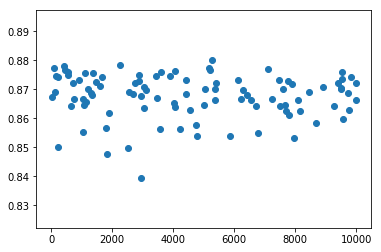

In [47]:
x = [seed[0] for seed in seeds]
y = [seed[1] for seed in seeds]

plt.scatter(x,y)

In [2]:
folder = '/media/data_1/darius/models/finetuned'
numFolds= 1000

sheets = ['overall', 'gender' ,'language', 'insurance', 'ethnicity']
model = 'baseline'
target = 'inhosp_mort'


In [3]:
dfs = {}
gap_infos_hyp = {}
gap_infos_naive = {}
for sheet in sheets:
    res = pd.DataFrame()
    for root, dirs, files in tqdm(os.walk(folder)):
        for d in dirs:
            mname = d
            if 'seed' not in mname:
                continue
            files = sorted([os.path.join(root, d, f) for f in os.listdir(os.path.join(root, d)) if 'results' in f or 'final_scores' in f]) 
            for file in files:
                if 'final_scores' in file:
                    df = pd.read_csv(file, ": ", header=None, index_col=0)
                    df = pd.DataFrame(df.values.transpose(), columns=df.index)
                    seed = str(int(df.Seed.item()))
                    continue

                

                print(f'Current finetuned model is {mname} with seed {seed}...')

                if sheet == 'overall':
                    print(os.path.join(root, file))
                    df = pd.read_excel(os.path.join(root, file), index_col=0, sheet_name = 'all')
                    column = 'all_auroc'
                    res.loc[target, seed + '_' + column] = df.loc[column, 'avg']
                    res.loc[target, seed + '_' + column +'lowerCI'] = df.loc[column, '2.5%']
                    res.loc[target, seed + '_' + column +'upperCI'] = df.loc[column, '97.5%']

                elif sheet == 'gender':
                    df = pd.read_excel(os.path.join(root, file), index_col=0, sheet_name = 'gender')
                    columns = ['gender=="M"_auroc', 'gender=="F"_auroc']

                    for i in columns:
                        res.loc[target, seed + '_' + i] = df.loc[i, 'avg']
                        res.loc[target, seed + '_' + i +'lowerCI'] = df.loc[i, '2.5%']
                        res.loc[target, seed + '_' + i +'upperCI'] = df.loc[i, '97.5%']
                
                elif sheet == 'language':
                    df = pd.read_excel(os.path.join(root, file), index_col=0, sheet_name = 'language_to_use')
                    columns = ['language_to_use=="English"_auroc', 'language_to_use=="Other"_auroc']

                    for i in columns:
                        res.loc[target, seed + '_' + i] = df.loc[i, 'avg']
                        res.loc[target, seed + '_' + i +'lowerCI'] = df.loc[i, '2.5%']
                        res.loc[target, seed + '_' + i +'upperCI'] = df.loc[i, '97.5%']
                                              
                elif sheet == 'insurance':                            
                    df = pd.read_excel(os.path.join(root, file), index_col=0, sheet_name = 'insurance')
                    columns = ['insurance=="Medicare"_auroc', 'insurance=="Private"_auroc', 'insurance=="Medicaid"_auroc']
       
                    for i in columns:
                        res.loc[target, seed + '_' + i] = df.loc[i, 'avg']
                        res.loc[target, seed + '_' + i +'lowerCI'] = df.loc[i, '2.5%']
                        res.loc[target, seed + '_' + i +'upperCI'] = df.loc[i, '97.5%']


                elif sheet == 'ethnicity':
                    df = pd.read_excel(os.path.join(root, file), index_col=0, sheet_name = 'ethnicity_to_use')
                    columns = ['ethnicity_to_use=="WHITE"_auroc', 'ethnicity_to_use=="BLACK"_auroc', 'ethnicity_to_use=="ASIAN"_auroc', 
                                'ethnicity_to_use=="HISPANIC/LATINO"_auroc', 'ethnicity_to_use=="OTHER"_auroc']

                    for i in columns:
                        res.loc[target, seed + '_' + i] = df.loc[i, 'avg']
                        res.loc[target, seed + '_' + i +'lowerCI'] = df.loc[i, '2.5%']
                        res.loc[target, seed + '_' + i +'upperCI'] = df.loc[i, '97.5%']
    
    
    # if sheet == 'gender':
    #     for m in allowed_models[sheet]:
    #         for i in ('Parity Gap (M-F)','Recall Gap','Specificity Gap'):
    #             add_gap(m, i, sheet, res)
                
    # if sheet == 'language':
    #     for m in allowed_models[sheet]:
    #         for i in ('Parity Gap (E-O)','Recall Gap','Specificity Gap'):
    #             add_gap(m, i, sheet, res)
    
    # if sheet == 'insurance':
    #     for m in allowed_models[sheet]:
    #         for g in ['Medicare', 'Private', 'Medicaid']:
    #             for i in ('"%s"_'%g + t for t in ['dgap_max','egap_positive_max','egap_negative_max']):
    #                 add_gap(m, i, sheet, res)
                    
    # if sheet == 'ethnicity':
    #     for m in allowed_models[sheet]:
    #         for g in ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC/LATINO', 'OTHER']:
    #             for i in ('"%s"_'%g + t for t in ['dgap_max','egap_positive_max','egap_negative_max']):
    #                 add_gap(m, i, sheet, res)
    
    dfs[sheet] = res.sort_index()

|          | 0/? [00:00<?, ?it/s]

dels/finetuned/inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1888/results.xlsx
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed8093 with seed 8093...
/media/data_1/darius/models/finetuned/inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed8093/results.xlsx
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed6542 with seed 6542...
/media/data_1/darius/models/finetuned/inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed6542/results.xlsx
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed562 with seed 562...
/media/data_1/darius/models/finetuned/inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed562/results.xlsx
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed6771 with seed 6771...
/media/data_1/darius/models/finetuned/inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_s

|          | 0/? [00:00<?, ?it/s]

Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1150 with seed 1150...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed9537 with seed 9537...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2669 with seed 2669...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1478 with seed 1478...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed6407 with seed 6407...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed7961 with seed 7961...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2561 with seed 2561...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1067 with seed 1067...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2895 w

|          | 0/? [00:00<?, ?it/s]

Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1150 with seed 1150...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed9537 with seed 9537...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2669 with seed 2669...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1478 with seed 1478...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed6407 with seed 6407...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed7961 with seed 7961...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2561 with seed 2561...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1067 with seed 1067...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2895 w

|          | 0/? [00:00<?, ?it/s]

Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1150 with seed 1150...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed9537 with seed 9537...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2669 with seed 2669...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1478 with seed 1478...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed6407 with seed 6407...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed7961 with seed 7961...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2561 with seed 2561...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1067 with seed 1067...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2895 w

|          | 0/? [00:00<?, ?it/s]

Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1150 with seed 1150...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed9537 with seed 9537...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2669 with seed 2669...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1478 with seed 1478...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed6407 with seed 6407...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed7961 with seed 7961...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2561 with seed 2561...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed1067 with seed 1067...
Current finetuned model is inhosp_mort_baseline_clinical_BERT_1_epoch_512_inhosp_mort_seed2895 w

In [30]:
def process_sheet(df):
    temp = defaultdict(dict)
    items = [(int(k.split('_')[0]), k.split('=="')[1].split('"_')[0], k.split('_')[-1], v.item()) for k, v in df.items()]

    for item in items:
        temp[(item[0], item[1])][item[2]] = item[3]

    rowlist = []
    for k, v in temp.items():
        row = {}
        row['seed'] = k[0]
        row['target'] = k[1]
        row['auroc'] = v['auroc']
        row['lower'] = v['auroclowerCI']
        row['upper'] = v['aurocupperCI']
        rowlist.append(row)

    return pd.DataFrame(rowlist).sort_values(['seed', 'target'])


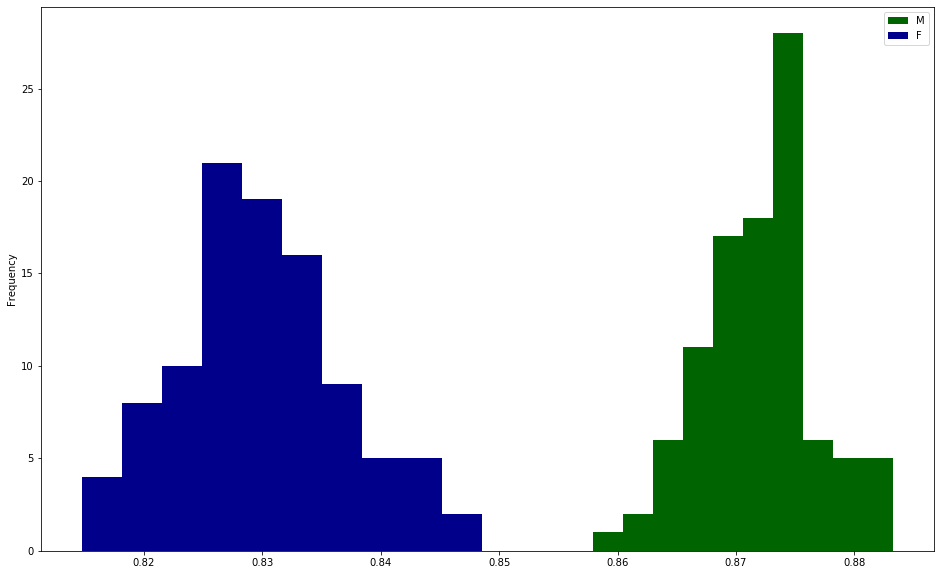

In [64]:
df = process_sheet(dfs['gender'])

ax = df[df.target == 'M'].plot.hist(x="seed", y="auroc", color="DarkGreen", label="M")
df[df.target == 'F'].plot.hist(x="seed", y="auroc", color="DarkBlue", label="F", ax=ax, figsize=(16,10))
# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 5))

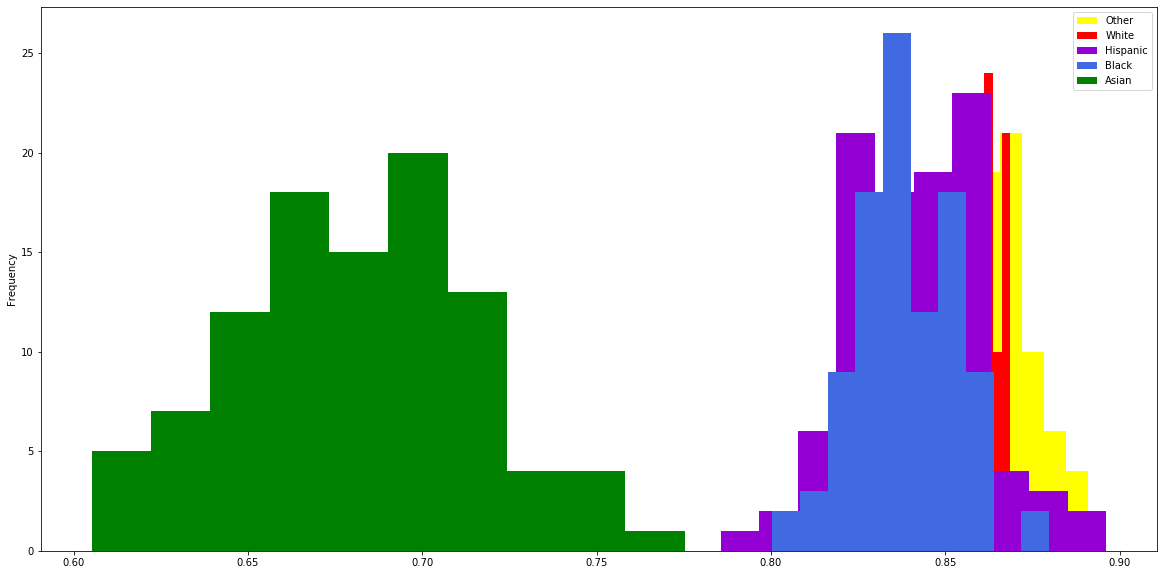

In [65]:
df = process_sheet(dfs['ethnicity'])

ax = df[df.target == 'OTHER'].plot.hist(x="seed", y="auroc", color="yellow", label="Other")
df[df.target == 'WHITE'].plot.hist(x="seed", y="auroc", color="red", label="White", ax=ax)
df[df.target == 'HISPANIC/LATINO'].plot.hist(x="seed", y="auroc", color="darkviolet", label="Hispanic", ax=ax)
df[df.target == 'BLACK'].plot.hist(x="seed", y="auroc", color="royalblue", label="Black", ax=ax)

df[df.target == 'ASIAN'].plot.hist(x="seed", y="auroc", color="green", label="Asian", ax=ax, figsize=(20,10))
# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 1))

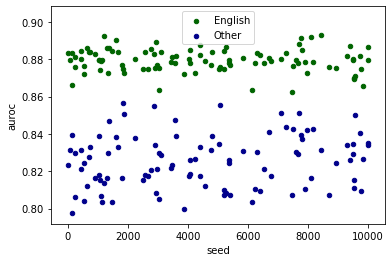

In [92]:
df = process_sheet(dfs['language'])

ax = df[df.target == 'English'].plot.scatter(x="seed", y="auroc", color="DarkGreen", label="English")
df[df.target == 'Other'].plot.scatter(x="seed", y="auroc", color="DarkBlue", label="Other", ax=ax)

In [58]:
df = process_sheet(dfs['insurance'])

ax = df[df.target == 'Medicare'].plot.scatter(x="seed", y="auroc", color="red", label="Medicare")
df[df.target == 'Private'].plot.scatter(x="seed", y="auroc", color="royalblue", label="Private", ax=ax)
df[df.target == 'Medicaid'].plot.scatter(x="seed", y="auroc", color="green", label="Medicaid", ax=ax)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 1))

t 0x7f5e77313c50>,
 ...]

Error in callback <function flush_figures at 0x7f5eb01b5b90> (for post_execute):


KeyboardInterrupt: 

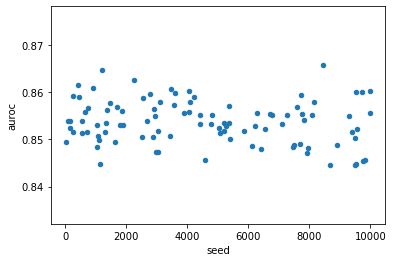

In [102]:
temp = defaultdict(dict)
items = [(int(k.split('_')[0]), k.split('_')[-1], v.item()) for k, v in dfs['overall'].items()]

for item in items:
    temp[item[0]][item[1]] = item[2]

rowlist = []
for k, v in temp.items():
    row = {}
    row['seed'] = k
    row['auroc'] = v['auroc']
    row['lower'] = v['auroclowerCI']
    row['upper'] = v['aurocupperCI']
    rowlist.append(row)

df = pd.DataFrame(rowlist)


df.plot.scatter(x="seed", y="auroc")

In [47]:
df = pd.concat([process_sheet(dfs[target]) for target in sheets if target != 'overall'])
df.to_csv('/home/darius/subgroup_auroc.csv', index=False)

In [43]:
df

,seed,target,auroc,lower,upper
147,15,F,0.824922,0.789673,0.858033
146,15,M,0.869564,0.839669,0.896942
69,96,F,0.830783,0.793480,0.862455
68,96,M,0.869892,0.843427,0.896161
177,144,F,0.825878,0.787503,0.861602
...,...,...,...,...,...
352,9991,ASIAN,0.694308,0.361607,0.966927
351,9991,BLACK,0.833736,0.720777,0.932120
353,9991,HISPANIC/LATINO,0.843584,0.727555,0.937201
354,9991,OTHER,0.833610,0.585392,1.000000
